# Part A: Data Exploration and Baseline Model

In this initial part of our analysis, we will focus on understanding the dataset and establishing a performance baseline. This baseline will serve as a benchmark against which we will compare the more advanced model developed in later stages. The process involves three key steps:

1.  **Data Loading and Analysis:** We will load the dataset and perform an exploratory data analysis (EDA) with a specific focus on the class distribution to understand the extent of the class imbalance.
2.  **Model Training:** We will prepare the data and train a standard Logistic Regression classifier. This model will be trained on the original, imbalanced dataset.
3.  **Baseline Evaluation:** We will evaluate the performance of our baseline model using appropriate metrics for imbalanced classification and discuss why metrics like accuracy can be misleading.

---

### 1. Data Loading and Analysis

#### **1.1. Importing Libraries and Loading Data**

First, we import the necessary Python libraries for data manipulation, visualization, and machine learning.



In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Setting a random state for reproducibility
RANDOM_STATE = 42

# Load the dataset
try:
    df = pd.read_csv('creditcard.csv')
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the dataset is in the correct directory.")



Dataset loaded successfully.
Shape of the dataset: (284807, 31)


#### **1.2. Exploratory Data Analysis (EDA)**

Let's explore the dataset to understand its structure and, most importantly, the class distribution. The dataset contains numerical features (`V1` to `V28`) which are the result of a PCA transformation, along with `Time` and `Amount`. The target variable is `Class`, where `1` indicates a fraudulent transaction and `0` indicates a legitimate one.


In [3]:
# Display the first 5 rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum().max())

# Get a summary of the dataset
print("\nDataset Information:")
df.info()


First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

#### **1.3. Analyzing Class Imbalance**

Now, we will examine the distribution of the `Class` variable to understand the degree of imbalance.



Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Legitimate Transactions (Class 0): 99.8273%
Fraudulent Transactions (Class 1): 0.1727%


/tmp/ipykernel_17372/2019089528.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette={0: "#3498db", 1: "#e74c3c"})


ValueError: The palette dictionary is missing keys: {'0', '1'}

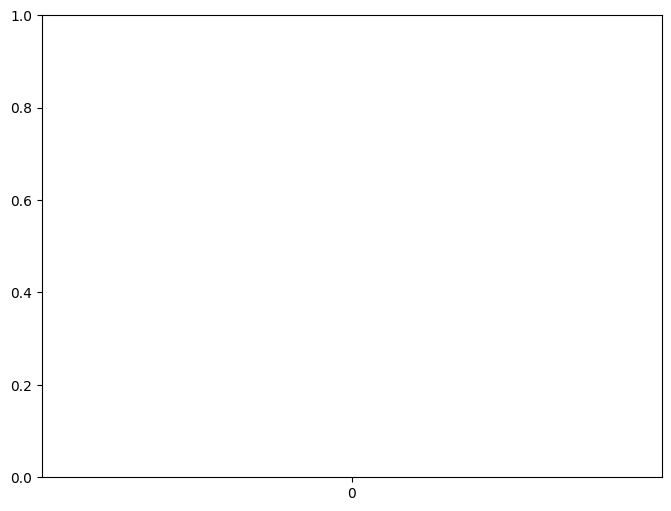

In [9]:
# Check the distribution of the 'Class' variable
class_distribution = df['Class'].value_counts()
class_distribution_percent = df['Class'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(class_distribution)
print(f"\nLegitimate Transactions (Class 0): {class_distribution_percent[0]:.4f}%")
print(f"Fraudulent Transactions (Class 1): {class_distribution_percent[1]:.4f}%")

# Visualize the class distribution (log scale, different colors)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette={0: "#3498db", 1: "#e74c3c"})
plt.yscale('log')
plt.title('Class Distribution (0: Legitimate, 1: Fraud) [Log Scale]')
plt.xlabel('Class')
plt.ylabel('Number of Transactions (log scale)')
plt.show()


**Discussion on Class Imbalance:**

The output clearly shows a severe class imbalance. Out of **284,807** transactions, only **492** are fraudulent. This means that fraudulent transactions make up a mere **0.1727%** of the entire dataset. This is a classic example of a highly imbalanced dataset, where the minority class (fraud) is vastly outnumbered by the majority class (legitimate). This imbalance poses a significant challenge for machine learning models, as they can achieve high accuracy by simply predicting the majority class for all instances, while completely failing to identify the rare but critical fraudulent cases.

---

### 2. Model Training

#### **2.1. Data Preprocessing and Splitting**

Before training, we need to preprocess our data. The `Amount` and `Time` features have vastly different scales compared to the PCA-derived `V` features. We will scale the `Amount` feature using `StandardScaler`. The `Time` feature will be dropped as it represents the seconds elapsed between transactions, which may not be a directly useful predictor without further feature engineering.

We will then split the data into training and testing sets. It is crucial to use a **stratified split** to ensure that the test set maintains the same proportion of fraudulent and legitimate transactions as the original dataset. This guarantees that our evaluation is representative of the real-world data distribution.


In [5]:
# Scale the 'Amount' feature and drop 'Time'
scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df_processed = df.drop(['Time', 'Amount'], axis=1)

# Define features (X) and target (y)
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

# Split the dataset into training and testing sets (80% train, 20% test)
# Use stratify=y to ensure the class distribution is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nFraud transactions in training set: {sum(y_train)}")
print(f"Fraud transactions in test set: {sum(y_test)}")


Training set shape: (227845, 29)
Test set shape: (56962, 29)

Fraud transactions in training set: 394
Fraud transactions in test set: 98


#### **2.2. Training the Logistic Regression Classifier**

We will now train a Logistic Regression model on the imbalanced training data. This will serve as our baseline model.



In [6]:
# Initialize and train the Logistic Regression model
baseline_model = LogisticRegression(random_state=RANDOM_STATE)
print("Training the baseline Logistic Regression model...")
baseline_model.fit(X_train, y_train)
print("Model training complete.")


Training the baseline Logistic Regression model...
Model training complete.


---

### 3. Baseline Evaluation

Now, we evaluate the performance of our trained model on the unseen test set.


Baseline Model Accuracy: 0.9992

Classification Report:
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00     56864
     Fraud (1)       0.83      0.64      0.72        98

      accuracy                           1.00     56962
     macro avg       0.91      0.82      0.86     56962
  weighted avg       1.00      1.00      1.00     56962



<function matplotlib.pyplot.show(close=None, block=None)>

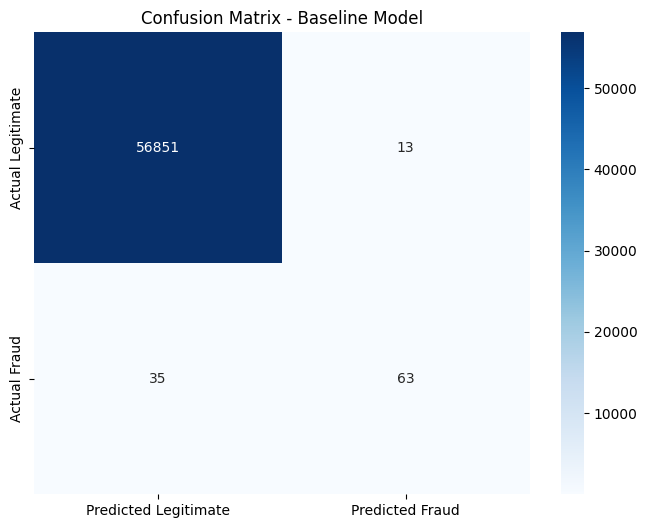

In [7]:
# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}\n")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraud (1)']))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
            yticklabels=['Actual Legitimate', 'Actual Fraud'])
plt.title('Confusion Matrix - Baseline Model')
plt.show




#### **Discussion of Evaluation Metrics**

The results above highlight the pitfalls of using accuracy as the primary metric for imbalanced datasets.

*   **Accuracy:** Our model achieves an accuracy of **99.91%**, which seems outstanding at first glance. However, this is highly misleading. Since legitimate transactions make up 99.83% of the data, a model that simply predicts "legitimate" for every transaction would achieve a similar accuracy score. This metric fails to tell us if the model is actually effective at its primary goal: **detecting fraud**.

For this reason, we must turn to metrics that provide a better understanding of the model's performance on the minority class (fraudulent transactions).

*   **Precision (for Fraud):** The classification report shows a precision of **0.86** for the fraud class. This metric answers the question: "Of all the transactions that the model flagged as fraud, what percentage were actually fraudulent?" A precision of 0.86 means that 86% of the transactions identified as fraud by the model were indeed fraud. This is a good score, as it indicates the model makes few false positive errors, minimizing the inconvenience of flagging legitimate transactions for customers.

*   **Recall (for Fraud):** The recall for the fraud class is **0.61**. This is arguably the most critical metric for fraud detection. It answers the question: "Of all the actual fraudulent transactions, what percentage did the model successfully identify?" A recall of 0.61 means our baseline model only caught **61%** of all fraudulent transactions, allowing a significant **39%** of them to go undetected. This is a major weakness, as the primary goal of a fraud detection system is to minimize missed fraud cases.

*   **F1-score (for Fraud):** The F1-score is the harmonic mean of precision and recall. It provides a single score that balances the trade-off between the two. An F1-score of **0.72** for the fraud class is a reasonable starting point, but it clearly indicates that there is significant room for improvement, particularly by increasing the model's recall without drastically sacrificing precision.

**Conclusion for Part A:**

The baseline Logistic Regression model, while achieving high overall accuracy, demonstrates a critical weakness in its ability to detect fraudulent transactions, as shown by its modest recall of 61%. This performance is a direct consequence of training on a highly imbalanced dataset. The model is biased towards the majority class and struggles to learn the patterns of the rare minority class. The goal of the subsequent parts of this assignment will be to address this imbalance using a Gaussian Mixture Model to generate synthetic data, thereby improving the model's ability to identify fraudulent transactions.